# CSC 594 HW\#4 XAI -- LIME (1): Explanations for ImageNet Categories
This code implements an XAI technique called LIME (Local Interpretable Model-agnostic Explanations) and demonstrates how it generates explanations for the predictions made by some off-the-shelf CNN models.  Those models are pretrained with ImageNet, and the code applies a few example images to classify them into ImageNet categories.

The code is adapted from the code by Cristian Arteaga, [arteagac.github.io](https://arteagac.github.io)

![banner](https://arteagac.github.io/blog/lime_image/img/lime_banner.png)


### Setup -- Google Drive Mounting

In [ ]:
## Code piece to mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive") # my Google root directory will be mapped here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the working directory to the work directory (where the code and data files are).
import os
os.chdir('/content/drive/My Drive/CSC594ADL-2020fall/XAI')

# Ensure the files are there (in the folder)
!ls -l

total 1338
-rw------- 1 root root 492902 Oct 26 18:27 boathouselakerousseau1.jpg
-rw------- 1 root root 208133 Oct 26 18:25 boathouserow.jpg
-rw------- 1 root root  36706 Oct 26 20:09 xai_integrated_gradients.ipynb
-rw------- 1 root root 630846 Oct 28 21:47 xai_lime_image.ipynb


### Imports
Import some of the necessary utilities for manipulation of images, plotting, CNN models and numerical analysis.

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

np.random.seed(222)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.0


### (1) Load Pre-trained Models from Keras

We use models available at [Keras Applications](https://keras.io/api/applications/) which are pre-trained with ImageNet.
We take the whole model, including the top classification part (i.e., off-the-shelf), in this experiment.

For now, we use three CNN models (InceptionV3, VGG16 and ResNet50).

In [ ]:
# InceptionV3
iv3_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=True) 

# VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

# ResNet50
resnet50_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

### (2) Load and pre-process images
First load a few example images. 

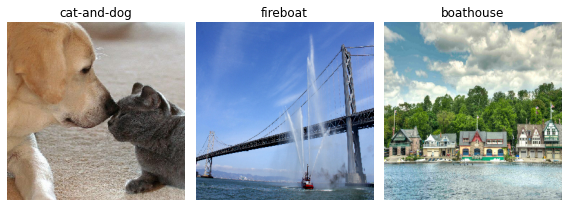

In [ ]:
# Load three images: two images from a URL and another from local drive.  
# The obtained images (orig_imgX) are still in the PIL Image format at this time.
# Note: All images are uniformly sized to (299,299) for now.
from IPython.display import Image

img_target_size = (299,299)

# image1:
path1 = tf.keras.utils.get_file("cat-and-dog.jpg", "https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
orig_img1 = tf.keras.preprocessing.image.load_img(path1, target_size=img_target_size)

# image2:
path2 = tf.keras.utils.get_file("San_Francisco_fireboat_showing_off.jpg", 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg')
orig_img2 = tf.keras.preprocessing.image.load_img(path2, target_size=img_target_size)

# image3:
orig_img3 = tf.keras.preprocessing.image.load_img('boathouserow.jpg', target_size=img_target_size)

#---------------
# Put them in a dictionary with image names
img_names = ['cat-and-dog', 'fireboat', 'boathouse']
img_name_map = {img_names[0] : orig_img1, img_names[1] : orig_img2, img_names[2] : orig_img3}

# Display the images
plt.figure(figsize=(8, 8))
for n, (name, orig_img) in enumerate(img_name_map.items()):
  ax = plt.subplot(1, 3, n+1)
  ax.imshow(orig_img)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()


In [ ]:
# Functions to preprocess an image, for a specific model.
import copy

def preprocess_image_for_model(orig_img, model_type):
  # First make a copy of the original image
  img = copy.deepcopy(orig_img)

  # Next make the img to the appropriate target size
  if model_type.startswith('inception') or model_type.startswith('mobilenet') or model_type == 'xception':
    target_size = (299, 299)
  else:
    target_size = (224, 224) # all other models use this size

  if img.size != target_size:
    img = img.resize(target_size)

  # Convert the image pixels to a (3D) numpy array
  x = tf.keras.preprocessing.image.img_to_array(img)

  # Finally call the appropriate 'process_input()' function for the model.
  # The function only scale the pixel values expected for the model (either [0,1] or [-1,1]).
  if model_type.startswith('inception') or model_type == 'xception': # anomaly, [-1,1]
    x = tf.keras.applications.inception_v3.preprocess_input(x)
  else:
    x = tf.keras.applications.vgg16.preprocess_input(x) # [0,1], vgg16 as the representative

  return x

### (3) Run Models and Obtain Predictions
Run the models and obtain predictions for each image.  For each model, the output of the classification is a vector of 1000 probabilities of beloging to each class in ImageNet.

We also save the top-K predictions (actually their indices in ImageNet) for future use.

In [ ]:
# Set k in top_k to be 5 for now
topk = 5

In [ ]:
# (3-1) InceptionV3 -- Look for 'iv3' in the lines

# Save the processed images and the prediction results in dictionaries
images_iv3 = {}
results_iv3 = {}

for (name, orig_img) in img_name_map.items():
  # First process the image
  processed_image = preprocess_image_for_model(orig_img, 'inceptionv3')
  images_iv3[name] = processed_image
  #print (processed_image.shape) # to ensure processing was successful

  # Run the model to obtain predictions
  # To do so, add the 0th dimension (batch_size) to make the image a 4D tensor (on the fly)
  preds = iv3_model.predict(np.expand_dims(processed_image, axis=0))
  top_pred_classes = preds[0].argsort()[-topk:][::-1] # indices of topk classes
  
  # 'Decode' the predictions
  results = tf.keras.applications.inception_v3.decode_predictions(preds, top=topk)[0]
  results_iv3[name] = [(index, result[1], result[2]) for index, result in zip(top_pred_classes, results)]

print (results_iv3)

{'cat-and-dog': [(208, 'Labrador_retriever', 0.76364595), (180, 'American_Staffordshire_terrier', 0.023073826), (207, 'golden_retriever', 0.0098592155), (246, 'Great_Dane', 0.009563548), (243, 'bull_mastiff', 0.009112368)], 'fireboat': [(554, 'fireboat', 0.8381231), (718, 'pier', 0.049333952), (839, 'suspension_bridge', 0.0047072633), (562, 'fountain', 0.0017299242), (510, 'container_ship', 0.0013377217)], 'boathouse': [(449, 'boathouse', 0.8891753), (975, 'lakeside', 0.010187835), (208, 'Labrador_retriever', 0.0011475725), (483, 'castle', 0.0010390324), (408, 'amphibian', 0.00093878683)]}


In [ ]:
# (3-2) VGG16 -- Look for 'vgg16' in the lines

# Save the processed images and the prediction results in dictionaries
images_vgg16 = {}
results_vgg16 = {}

for (name, orig_img) in img_name_map.items():
  # First process the image
  processed_image = preprocess_image_for_model(orig_img, 'vgg16') 
  #print (processed_image.shape) # to ensure processing was successful
  images_vgg16[name] = processed_image

  # Run the model to obtain predictions
  # To do so, add the 0th dimension (batch_size) to make the image a 4D tensor (on the fly)
  preds = vgg16_model.predict(np.expand_dims(processed_image, axis=0))
  top_pred_classes = preds[0].argsort()[-topk:][::-1]

  # 'Decode' the predictions
  results = tf.keras.applications.vgg16.decode_predictions(preds, top=topk)[0]
  results_vgg16[name] = [(index, result[1], result[2]) for index, result in zip(top_pred_classes, results)]

print (results_vgg16)

{'cat-and-dog': [(208, 'Labrador_retriever', 0.11314377), (180, 'American_Staffordshire_terrier', 0.0713713), (207, 'golden_retriever', 0.040195704), (273, 'dingo', 0.03423259), (179, 'Staffordshire_bullterrier', 0.033776607)], 'fireboat': [(554, 'fireboat', 0.9888405), (718, 'pier', 0.0053391065), (510, 'container_ship', 0.0010395787), (540, 'drilling_platform', 0.0008891301), (628, 'liner', 0.00073187944)], 'boathouse': [(449, 'boathouse', 0.6745781), (975, 'lakeside', 0.2448263), (977, 'sandbar', 0.0094527), (536, 'dock', 0.0074327877), (576, 'gondola', 0.0044329185)]}


In [ ]:
# (3-3) ResNet50 -- Look for 'resnet50' in the lines

# Save the processed images and the prediction results in dictionaries
images_resnet50 = {}
results_resnet50 = {}

for (name, orig_img) in img_name_map.items():
  # First process the image
  processed_image = preprocess_image_for_model(orig_img, 'resnet50') 
  images_resnet50[name] = processed_image
  #print (processed_image.shape) # to ensure processing was successful

  # Run the model to obtain predictions
  # To do so, add the 0th dimension (batch_size) to make the image a 4D tensor (on the fly)
  preds = resnet50_model.predict(np.expand_dims(processed_image, axis=0))
  top_pred_classes = preds[0].argsort()[-topk:][::-1]

  # 'Decode' the predictions
  results = tf.keras.applications.resnet50.decode_predictions(preds, top=topk)[0]
  results_resnet50[name] = [(index, result[1], result[2]) for index, result in zip(top_pred_classes, results)]

print (results_resnet50)

{'cat-and-dog': [(208, 'Labrador_retriever', 0.97140247), (207, 'golden_retriever', 0.0105743315), (209, 'Chesapeake_Bay_retriever', 0.0035356935), (260, 'chow', 0.0017271853), (222, 'kuvasz', 0.0016439712)], 'fireboat': [(554, 'fireboat', 0.92477316), (718, 'pier', 0.06595541), (839, 'suspension_bridge', 0.007044245), (517, 'crane', 0.0004049309), (628, 'liner', 0.00039070347)], 'boathouse': [(449, 'boathouse', 0.4991696), (975, 'lakeside', 0.36131132), (536, 'dock', 0.058497388), (977, 'sandbar', 0.011720304), (483, 'castle', 0.010817069)]}


## (4) LIME explanations

From here on, we focus on one CNN model and one example image at a time.  

**NOTE**: You can change the values and code here for your experimentation.

In [ ]:
# Define the model to use and its associated variables saved earlier.
model_type = 'inceptionv3'
model = iv3_model #
image_map = images_iv3
results_map = results_iv3

# Define the image to use
image_name_to_use = img_names[0] # 'cat-and-dog'
Xi = image_map[image_name_to_use] # Xi is the orig_img

### Step 1: Create perturbations of image
For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

#### Extract super-pixels from image
Superpixels are generated using the quickshift segmentation algorithm. 

In [ ]:
import skimage.io 
import skimage.segmentation

superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
print ('Number of superpixdels: %s' % num_superpixels)

Number of superpixdels: 60


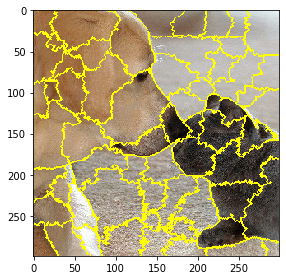

In [ ]:
# Fix up the image just for displaying (because inception's [-1,1] range 
# causes problems for displaying image with boundaries).
if (model_type.startswith('inception') or model_type.startswith('mobilenet') or model_type == 'xception'):
  img2 = Xi/2+0.5
else:
  img2 = Xi

# Display image with boundaries
skimage.io.imshow(skimage.segmentation.mark_boundaries(img2, superpixels))

#### Create random perturbations
In this code, we use 150 perturbations. However, for real life applications, a larger number of perturbations will produce more reliable explanations. 

A perturbation is essentially a mask (a vector of 0' and 1's) over superpixels, where `1` represents that a superpixel is on and `0` represents it is off. 

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

The following function `perturb_image` perturbs the given image (`img`) based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

Let's use the previous function (and the appropriated image 'img2') to see what a perturbed image would look like:

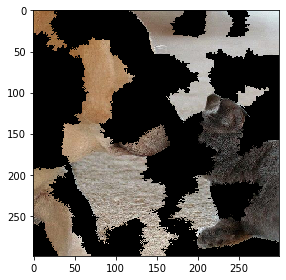

In [ ]:
skimage.io.imshow(perturb_image(img2,perturbations[3],superpixels)) # [3] is an arbitrary choice

### Step 2: Use ML classifier to predict classes of new generated images
This is the most computationally expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the 1000 classes. 

In [ ]:
predictions = []
for pert in perturbations: # for each perturbation mask,
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:]) # add batch_size dimension to predict
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

### Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. For the shape of the `distances` array it can be noted that, as expected, there is a distance for every generated perturbation.

In [ ]:
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

#### Use kernel function to compute weights
The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

<img src="https://arteagac.github.io/blog/lime_image/img/kernel.png" alt="Drawing" width="600"/>

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

### Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is labrador, when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of labrador.

In [ ]:
# Define the class in the predictions for which we generate explanation.
# From the earlier prediction results of the chosen model, we choose the class
# with the highest probability (which is at the 0th slot in the vector).
class_to_explain = results_map[image_name_to_use][0][0] # first [0] is for class index

# Then create a simpler model and fit it.  Weights are applied on instances (which are perturbations).
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.04633497,  0.05166969,  0.00482914, -0.00937685, -0.01533452,
       -0.00406577,  0.00086671,  0.0042047 ,  0.17850689, -0.03277784,
       -0.01366271,  0.04642949, -0.04276044, -0.05998694,  0.0021638 ,
       -0.01943765,  0.09121367,  0.02940533,  0.05252173,  0.02250589,
        0.04392162,  0.03463109,  0.05573654, -0.01328712,  0.0139152 ,
       -0.02496964,  0.3200123 , -0.03961367,  0.02769133,  0.01949975,
        0.00971881, -0.03821108,  0.08545992, -0.00154122,  0.02170684,
       -0.01141379,  0.00683579,  0.00489876,  0.01891389, -0.02704391,
       -0.01505721,  0.03573717, -0.02098994,  0.02804096, -0.05742059,
       -0.01210016, -0.02229653,  0.10867985,  0.02912872,  0.00230075,
       -0.03676141, -0.06934741, -0.03560219,  0.00452564, -0.00713404,
        0.11038177, -0.01445052,  0.01838979, -0.01582292, -0.06291103])

#### Compute top features (superpixels)
Now we just need to sort the coefficients to figure out which are the supperpixels that have larger coefficients (magnitude) for the prediction of labradors. The identifiers of these top features or superpixels are shown below. Even though here we use the magnitude of the coefficients to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection. 

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([47, 55,  8, 26])

#### Show LIME explanation (image with top features)
Let's show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

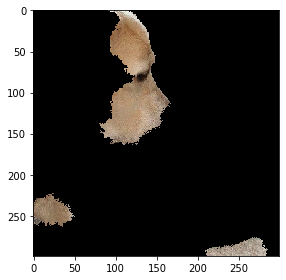

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img2,mask,superpixels) )